In [50]:
# import modules
import os
import pandas as pd
import pickle
import shap
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import pingouin as pg

# import visualization modules
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

In [79]:
cwd = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(cwd, ".."))

# build paths inside the repo
get_data_path = lambda folders, fname: os.path.normpath(
    os.path.join(BASE_DIR, *folders, fname)
)

# breast cancer cell lines
breast_cancer_path = get_data_path(['output', 'breast_cancer'], 'paralog_pairs_breast_cancer_df_fully_annotated_with_essentials.parquet')

# models
file_RF_model_early = get_data_path(['output', 'models'], 'early_integration_model.pickle')
file_RF_model_late = get_data_path(['output', 'models'], 'late_integration_model.pickle')

figure_path_box_plot_her = get_data_path(['figures'], 'box_plots_her_mutated.png')


In [52]:
breast_cancer_df = pd.read_parquet(breast_cancer_path)
breast_cancer_df = breast_cancer_df.rename(columns={'smallest_CC_GO_expression': 'go_CC_expression'})
breast_cancer_df[:3]

,prediction_rank,prediction_percentile,old_genepair,genepair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,...,smallest_BP_GO_expression,smallest_CC_GO_essentiality,A1_rank,zA1_rank,A2_rank,zA2_rank,max_ranked_A1A2,min_ranked_A1A2,z_max_ranked_A1A2,z_min_ranked_A1A2
0,1,0.1,SMARCA2_SMARCA4,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,...,4.265264,5189.875,14677.0,0.656169,491.0,-0.947882,14677.0,491.0,0.656169,-0.947882
1,1,0.1,SMARCA2_SMARCA4,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,...,4.535862,7734.375,15721.0,0.913013,1854.0,-0.614466,15721.0,1854.0,0.913013,-0.614466
2,1,0.1,SMARCA2_SMARCA4,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,...,4.881678,8400.250,14888.0,0.708079,7562.0,0.781824,14888.0,7562.0,0.781824,0.708079


In [53]:
breast_cancer_df.genepair.nunique(), breast_cancer_df.shape[0]

(33574, 1510830)

In [54]:
feature_columns_1 = ['rMaxExp_A1A2', 'rMinExp_A1A2',
                     'max_ranked_A1A2', 'min_ranked_A1A2',
                     'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 
                     'min_sequence_identity',
                     'prediction_score', 
                     'weighted_PPI_essentiality', 'weighted_PPI_expression',
                     'smallest_BP_GO_essentiality', 'smallest_CC_GO_essentiality',
                     'smallest_BP_GO_expression', 'go_CC_expression'
                     ]

#target_column = 'SL_08'

print('num of features:', len(feature_columns_1))

num of features: 16


In [55]:
feature_columns_2 = feature_columns_1 + ['closest', 'WGD', 'family_size',
                                         'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog',
                                         'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog',
                                         'has_essential_cerevisiae_ortholog', 'conservation_score', 'mean_age',
                                         'either_in_complex', 'mean_complex_essentiality', 'colocalisation',
                                         'interact', 'n_total_ppi', 'fet_ppi_overlap',
                                         'gtex_spearman_corr', 'gtex_min_mean_expr', 'gtex_max_mean_expr']
feature_columns_2.remove('prediction_score')
print('num of features:', len(feature_columns_2))

num of features: 35


In [56]:
breast_cancer_df[feature_columns_1].isna().sum()

rMaxExp_A1A2                   0
rMinExp_A1A2                   0
max_ranked_A1A2                0
min_ranked_A1A2                0
max_cn                         0
min_cn                         0
Protein_Altering               0
Damaging                       0
min_sequence_identity          0
prediction_score               0
weighted_PPI_essentiality      0
weighted_PPI_expression        0
smallest_BP_GO_essentiality    0
smallest_CC_GO_essentiality    0
smallest_BP_GO_expression      0
go_CC_expression               0
dtype: int64

In [57]:
# Load RF classifier from file
with open(file_RF_model_early, 'rb') as file:
    early = pickle.load(file)

In [58]:
# predicitons for all ~36.6k paralog pairs
ypred_early = early.predict_proba(breast_cancer_df[feature_columns_1])[:,1]
all_predictions = breast_cancer_df.assign(early_prediction_score=ypred_early)

In [59]:
# Load RF classifier from file
with open(file_RF_model_late, 'rb') as file:
    late = pickle.load(file)

In [60]:
# predicitons for all ~36.6k paralog pairs
ypred_late = late.predict_proba(breast_cancer_df[feature_columns_2])[:,1]
all_predictions = all_predictions.assign(late_prediction_score=ypred_late)

In [61]:
all_predictions = all_predictions.sort_values(['late_prediction_score', 'early_prediction_score'], ascending=False)
all_predictions.head()

,prediction_rank,prediction_percentile,old_genepair,genepair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,...,A1_rank,zA1_rank,A2_rank,zA2_rank,max_ranked_A1A2,min_ranked_A1A2,z_max_ranked_A1A2,z_min_ranked_A1A2,early_prediction_score,late_prediction_score
271,7,0.1,HDAC1_HDAC2,HDAC1_HDAC2,HDAC1,HDAC2,3065,3066,ENSG00000116478,ENSG00000196591,...,3368.0,-0.886165,9660.0,-0.164687,9660.0,3368.0,-0.164687,-0.886165,0.777927,0.864835
313,7,0.1,HDAC1_HDAC2,HDAC1_HDAC2,HDAC1,HDAC2,3065,3066,ENSG00000116478,ENSG00000196591,...,5537.0,-0.276839,8586.0,-0.414039,8586.0,5537.0,-0.276839,-0.414039,0.765877,0.861404
279,7,0.1,HDAC1_HDAC2,HDAC1_HDAC2,HDAC1,HDAC2,3065,3066,ENSG00000116478,ENSG00000196591,...,8400.0,0.527449,6492.0,-0.900207,8400.0,6492.0,0.527449,-0.900207,0.785032,0.858368
275,7,0.1,HDAC1_HDAC2,HDAC1_HDAC2,HDAC1,HDAC2,3065,3066,ENSG00000116478,ENSG00000196591,...,3660.0,-0.804135,11951.0,0.367219,11951.0,3660.0,0.367219,-0.804135,0.743945,0.849749
314,7,0.1,HDAC1_HDAC2,HDAC1_HDAC2,HDAC1,HDAC2,3065,3066,ENSG00000116478,ENSG00000196591,...,6025.0,-0.139748,10167.0,-0.046976,10167.0,6025.0,-0.046976,-0.139748,0.738572,0.844294


In [62]:
all_predictions_her_labeled = all_predictions.copy()
all_predictions_her_labeled = all_predictions_her_labeled.assign(
    mut_binary=all_predictions_her_labeled['her_label'].map({
        'her2_neg': 0,
        'her2_pos': 1,
        'unknown': np.nan
    })
)

all_predictions_her_labeled['mut_binary'].value_counts()

mut_binary
0.0    1107942
1.0     335740
Name: count, dtype: int64

In [63]:
all_predictions_rb1_labeled = all_predictions.copy()
all_predictions_rb1_labeled = all_predictions_rb1_labeled.assign(
    mut_binary=all_predictions_rb1_labeled['rb1_defects'].map({
        'wt': 0,
        'RB1 defective': 1,
        'unknown': np.nan
    })
)

all_predictions_rb1_labeled['mut_binary'].value_counts()

mut_binary
0.0    604332
1.0    235018
Name: count, dtype: int64

## p value calculation

In [64]:
def calculate_pvalues_for_genepairs(data_df, score_column='late_prediction_score'):
    """
    Calculate p-values and effect sizes for gene pairs comparing WT vs MUT groups.
    
    Parameters:
    - data_df: DataFrame with columns ['genepair', score_column, 'mut_binary']
    - score_column: Name of the column containing prediction scores
    
    Returns:
    - DataFrame with statistical test results for each gene pair
    """
    results = []
    
    for pair, group_df in data_df.groupby("genepair"):
        wt_scores = group_df[group_df["mut_binary"] == 0][score_column]
        mut_scores = group_df[group_df["mut_binary"] == 1][score_column]
        
        # Check if both groups have data
        if len(wt_scores) > 0 and len(mut_scores) > 0:
            # Perform Mann-Whitney U test
            mwu_result = pg.mwu(wt_scores, mut_scores, alternative="two-sided")
            p_val_mwu = mwu_result["p-val"].values[0]
            cles = mwu_result["CLES"].values[0]

            # Perform t-test
            ttest_result = pg.ttest(wt_scores, mut_scores, paired=False, alternative="two-sided")
            p_val_ttest = ttest_result["p-val"].values[0]
            cohens_d = ttest_result["cohen-d"].values[0]
            
            # Compute medians to determine effect direction
            median_wt = wt_scores.median()
            median_mut = mut_scores.median()
            
            # Determine effect direction
            if median_wt > median_mut:
                effect = "WT > MUT"
                sensitivity = "WT cell lines are more sensitive"
            elif median_wt < median_mut:
                effect = "MUT > WT"
                sensitivity = "MUT cell lines are more sensitive"
            else:
                effect = "No difference"
                sensitivity = "No difference in sensitivity"
                
            results.append({
                "genepair": pair, 
                "p_val_mwu": p_val_mwu, 
                "cles": cles, 
                "p_val_ttest": p_val_ttest, 
                "cohen_d": cohens_d, 
                "median_wt": median_wt, 
                "median_mut": median_mut, 
                "effect": effect, 
                "sensitivity": sensitivity,
                "n_wt": len(wt_scores),
                "n_mut": len(mut_scores)
            })
        else:
            # Handle cases where one or both groups are empty
            results.append({
                "genepair": pair,
                "p_val_mwu": np.nan,
                "cles": np.nan,
                "p_val_ttest": np.nan,
                "cohen_d": np.nan,
                "median_wt": wt_scores.median() if len(wt_scores) > 0 else np.nan,
                "median_mut": mut_scores.median() if len(mut_scores) > 0 else np.nan,
                "effect": "Insufficient data",
                "sensitivity": "Cannot determine",
                "n_wt": len(wt_scores),
                "n_mut": len(mut_scores)
            })
    
    return pd.DataFrame(results)

In [65]:
pval_calc_all_pairs_rb1 = all_predictions_rb1_labeled[['genepair', 'late_prediction_score', 'mut_binary']].copy()
pval_calc_all_pairs_rb1 = pval_calc_all_pairs_rb1.dropna(axis=0, how='any', subset=['mut_binary']).reset_index(drop=True)

pval_dir_df_rb1_alt = calculate_pvalues_for_genepairs(pval_calc_all_pairs_rb1)
pval_dir_df_rb1_alt

,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
0,A1BG_OSCAR,0.657279,0.436508,0.702296,0.188400,0.007080,0.012266,MUT > WT,MUT cell lines are more sensitive,18,7
1,A1BG_TARM1,0.495398,0.404762,0.856221,0.082416,0.003497,0.011211,MUT > WT,MUT cell lines are more sensitive,18,7
2,A1CF_DND1,0.836168,0.531746,0.239323,0.384435,0.016980,0.014799,WT > MUT,WT cell lines are more sensitive,18,7
3,A1CF_HNRNPR,0.177508,0.317460,0.072471,0.658136,0.227769,0.252366,MUT > WT,MUT cell lines are more sensitive,18,7
4,A1CF_RBM46,0.533901,0.412698,0.237354,0.345197,0.002591,0.007134,MUT > WT,MUT cell lines are more sensitive,18,7
...,...,...,...,...,...,...,...,...,...,...,...
33569,ZSWIM6_ZSWIM8,0.326079,0.365079,0.935494,0.029997,0.012827,0.031842,MUT > WT,MUT cell lines are more sensitive,18,7
33570,ZXDA_ZXDB,0.882605,0.523810,0.294788,0.308094,0.012735,0.013379,MUT > WT,MUT cell lines are more sensitive,18,7
33571,ZXDA_ZXDC,0.244306,0.658730,0.151331,0.413976,0.001297,0.000426,WT > MUT,WT cell lines are more sensitive,18,7
33572,ZXDB_ZXDC,0.700720,0.444444,0.132524,0.443183,0.000453,0.000798,MUT > WT,MUT cell lines are more sensitive,18,7


In [66]:
display(pval_dir_df_rb1_alt.loc[pval_dir_df_rb1_alt['genepair'] == 'PIK3C3_PIK3CA'])

display(pval_dir_df_rb1_alt.loc[pval_dir_df_rb1_alt['genepair'] == 'CDK4_CDK6'])

display(pval_dir_df_rb1_alt.loc[pval_dir_df_rb1_alt['genepair'] == 'AKT1_AKT2'])
display(pval_dir_df_rb1_alt.loc[pval_dir_df_rb1_alt['genepair'] == 'AKT1_AKT3'])
display(pval_dir_df_rb1_alt.loc[pval_dir_df_rb1_alt['genepair'] == 'AKT2_AKT3'])

,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
21878,PIK3C3_PIK3CA,0.004897,0.857143,0.009774,1.648686,0.398794,0.154006,WT > MUT,WT cell lines are more sensitive,18,7


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
4864,CDK4_CDK6,0.055182,0.753968,0.099836,1.070247,0.428372,0.278676,WT > MUT,WT cell lines are more sensitive,18,7


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
1294,AKT1_AKT2,0.495398,0.595238,0.447717,0.349402,0.181445,0.069824,WT > MUT,WT cell lines are more sensitive,18,7


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
1295,AKT1_AKT3,0.614941,0.571429,0.508374,0.283958,0.086628,0.058644,WT > MUT,WT cell lines are more sensitive,18,7


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
1307,AKT2_AKT3,0.614941,0.428571,0.953785,0.025615,0.020801,0.015706,WT > MUT,WT cell lines are more sensitive,18,7


In [67]:
pval_calc_all_pairs_her = all_predictions_her_labeled[['genepair', 'late_prediction_score', 'mut_binary']].copy()
pval_calc_all_pairs_her = pval_calc_all_pairs_her.dropna(axis=0, how='any', subset=['mut_binary']).reset_index(drop=True)

pval_dir_df_her_alt = calculate_pvalues_for_genepairs(pval_calc_all_pairs_her)
pval_dir_df_her_alt

,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
0,A1BG_OSCAR,0.396402,0.590909,0.018850,0.492262,0.009359,0.007491,WT > MUT,WT cell lines are more sensitive,33,10
1,A1BG_TARM1,0.396402,0.590909,0.016953,0.527778,0.005563,0.007059,MUT > WT,MUT cell lines are more sensitive,33,10
2,A1CF_DND1,0.965604,0.493939,0.961076,0.019336,0.014799,0.017868,MUT > WT,MUT cell lines are more sensitive,33,10
3,A1CF_HNRNPR,0.029971,0.730303,0.039109,0.746281,0.229203,0.192633,WT > MUT,WT cell lines are more sensitive,33,10
4,A1CF_RBM46,0.851769,0.521212,0.683081,0.123403,0.002280,0.002937,MUT > WT,MUT cell lines are more sensitive,33,10
...,...,...,...,...,...,...,...,...,...,...,...
33569,ZSWIM6_ZSWIM8,0.919854,0.487879,0.959964,0.017716,0.027802,0.017034,WT > MUT,WT cell lines are more sensitive,33,10
33570,ZXDA_ZXDB,0.594838,0.442424,0.566743,0.241679,0.012147,0.016340,MUT > WT,MUT cell lines are more sensitive,33,10
33571,ZXDA_ZXDC,0.784772,0.469697,0.299876,0.216352,0.000819,0.002212,MUT > WT,MUT cell lines are more sensitive,33,10
33572,ZXDB_ZXDC,0.829292,0.524242,0.760166,0.119510,0.000798,0.000235,WT > MUT,WT cell lines are more sensitive,33,10


In [68]:
display(pval_dir_df_her_alt.loc[pval_dir_df_her_alt['genepair'] == 'PIK3C3_PIK3CA'])

display(pval_dir_df_her_alt.loc[pval_dir_df_her_alt['genepair'] == 'CDK4_CDK6'])

display(pval_dir_df_her_alt.loc[pval_dir_df_her_alt['genepair'] == 'AKT1_AKT2'])
display(pval_dir_df_her_alt.loc[pval_dir_df_her_alt['genepair'] == 'AKT1_AKT3'])
display(pval_dir_df_her_alt.loc[pval_dir_df_her_alt['genepair'] == 'AKT2_AKT3'])

,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
21878,PIK3C3_PIK3CA,0.211103,0.366667,0.010428,0.630365,0.343126,0.386759,MUT > WT,MUT cell lines are more sensitive,33,10


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
4864,CDK4_CDK6,0.536522,0.433333,0.399795,0.243118,0.366394,0.389492,MUT > WT,MUT cell lines are more sensitive,33,10


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
1294,AKT1_AKT2,0.019131,0.251515,0.008318,1.053653,0.166729,0.465281,MUT > WT,MUT cell lines are more sensitive,33,10


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
1295,AKT1_AKT3,0.08199,0.315152,0.093395,0.671013,0.07628,0.174811,MUT > WT,MUT cell lines are more sensitive,33,10


,genepair,p_val_mwu,cles,p_val_ttest,cohen_d,median_wt,median_mut,effect,sensitivity,n_wt,n_mut
1307,AKT2_AKT3,0.307466,0.609091,0.093975,0.47968,0.027694,0.013717,WT > MUT,WT cell lines are more sensitive,33,10


In [ ]:
# file_pvalues = get_data_path(['output', 'breast_cancer'], 'pvalues.xlsx')

# # Create a Pandas Excel writer using XlsxWriter as the engine
# with pd.ExcelWriter(file_pvalues, engine='xlsxwriter') as writer:
#     # Write each DataFrame to a different worksheet
#     pval_dir_df_rb1_alt.to_excel(writer, sheet_name='RB1', index=False)
#     pval_dir_df_her_alt.to_excel(writer, sheet_name='ERBB2', index=False)

## Multiple Testing Correction

**The Problem:**
- You're testing thousands of gene pairs for significant differences
- With p < 0.05, you expect 5% false positives by chance
- If you test 1000 pairs, you'd get ~50 false positives even if there's no real difference!

**The Solution:**
- **FDR (False Discovery Rate) correction**: Controls the proportion of false discoveries
- **Benjamini-Hochberg method**: A popular FDR method that's less conservative than Bonferroni
- It adjusts p-values upward to account for multiple testing

**How to Use:**
1. Run your statistical tests (you already did this!)
2. Apply correction: `apply_multiple_testing_correction(your_dataframe)`
3. Use the `p_val_mwu_corrected` column for interpretation
4. Use the `p_val_mwu_significant` column to filter significant results

In [69]:
# Apply multiple testing correction to your results
def apply_multiple_testing_correction(df, p_col='p_val_mwu', method='fdr_bh', alpha=0.05):
    """
    Apply multiple testing correction to p-values.
    
    Parameters:
    - df: DataFrame with p-values
    - p_col: Column name containing p-values (default: 'p_val_mwu')
    - method: Correction method (default: 'fdr_bh')
        Available methods: 'bonferroni', 'sidak', 'holm-sidak', 'holm', 
        'simes-hochberg', 'hommel', 'fdr_bh', 'fdr_by', 'fdr_tsbh', 'fdr_tsbky'
    - alpha: Family-wise error rate (default: 0.05)
    
    Returns:
    - DataFrame with corrected p-values and significance flags
    
    Raises:
    - ValueError: If p_col not found in DataFrame or invalid method
    """
    # Validate inputs
    if p_col not in df.columns:
        raise ValueError(f"Column '{p_col}' not found in DataFrame")
    
    if not 0 < alpha < 1:
        raise ValueError(f"Alpha must be between 0 and 1, got {alpha}")
    
    valid_methods = ['bonferroni', 'sidak', 'holm-sidak', 'holm', 'simes-hochberg', 
                     'hommel', 'fdr_bh', 'fdr_by', 'fdr_tsbh', 'fdr_tsbky']
    if method not in valid_methods:
        raise ValueError(f"Method '{method}' not supported. Choose from: {valid_methods}")
    
    # Remove NaN values for correction
    valid_mask = ~df[p_col].isna()
    
    if valid_mask.sum() > 0:  # Check if there are valid p-values
        corrected_pvals = np.full(len(df), np.nan)
        significance_flags = np.full(len(df), False)
        
        # Apply correction only to valid p-values
        valid_pvals = df.loc[valid_mask, p_col].values
        
        try:
            rejected, pvals_corrected, alpha_sidak, alpha_bonf = multipletests(
                valid_pvals, alpha=alpha, method=method
            )
            
            # Put corrected values back
            corrected_pvals[valid_mask] = pvals_corrected
            significance_flags[valid_mask] = rejected  # Use the 'rejected' array from multipletests
            
        except Exception as e:
            print(f"Warning: Multiple testing correction failed: {e}")
            # Fallback: use original p-values
            corrected_pvals[valid_mask] = valid_pvals
            significance_flags[valid_mask] = valid_pvals < alpha
        
        # Add corrected p-values and significance flags
        df_corrected = df.copy()
        df_corrected[f'{p_col}_corrected'] = corrected_pvals
        df_corrected[f'{p_col}_significant'] = significance_flags
        
        return df_corrected
    else:
        # If no valid p-values, just add NaN columns
        df_corrected = df.copy()
        df_corrected[f'{p_col}_corrected'] = np.nan
        df_corrected[f'{p_col}_significant'] = False
        print(f"Warning: No valid p-values found in column '{p_col}'")
        return df_corrected

# Apply correction to YOUR data (the ones you created with the function)
print("Applying multiple testing correction...")
print("="*50)

# Apply correction to RB1 data
pval_dir_df_rb1_corrected = apply_multiple_testing_correction(pval_dir_df_rb1_alt, p_col='p_val_mwu', method='fdr_bh')

# Apply correction to HER2 data  
pval_dir_df_her_corrected = apply_multiple_testing_correction(pval_dir_df_her_alt, p_col='p_val_mwu', method='fdr_bh')

# Show results
print(f"RB1 dataset:")
print(f"  Total gene pairs tested: {len(pval_dir_df_rb1_alt)}")
print(f"  Significant before correction (p < 0.05): {(pval_dir_df_rb1_alt['p_val_mwu'] < 0.05).sum()}")
print(f"  Significant after FDR correction: {(pval_dir_df_rb1_corrected['p_val_mwu_significant']).sum()}")

print(f"\nHER2 dataset:")
print(f"  Total gene pairs tested: {len(pval_dir_df_her_alt)}")
print(f"  Significant before correction (p < 0.05): {(pval_dir_df_her_alt['p_val_mwu'] < 0.05).sum()}")
print(f"  Significant after FDR correction: {(pval_dir_df_her_corrected['p_val_mwu_significant']).sum()}")

# Show what columns were added
print(f"\nNew columns added:")
print(f"  - p_val_mwu_corrected: FDR-corrected p-values")
print(f"  - p_val_mwu_significant: True if corrected p-value < 0.05")

Applying multiple testing correction...
RB1 dataset:
  Total gene pairs tested: 33574
  Significant before correction (p < 0.05): 1935
  Significant after FDR correction: 0

HER2 dataset:
  Total gene pairs tested: 33574
  Significant before correction (p < 0.05): 2879
  Significant after FDR correction: 0

New columns added:
  - p_val_mwu_corrected: FDR-corrected p-values
  - p_val_mwu_significant: True if corrected p-value < 0.05


In [70]:
# Examine the most significant results after correction

print("TOP 10 MOST SIGNIFICANT GENE PAIRS - RB1")
print("="*60)
rb1_significant = pval_dir_df_rb1_corrected[pval_dir_df_rb1_corrected['p_val_mwu_significant']].copy()
rb1_top = rb1_significant.sort_values('p_val_mwu_corrected').head(10)

if len(rb1_top) > 0:
    for idx, row in rb1_top.iterrows():
        print(f"{row['genepair']:20} | p_raw={row['p_val_mwu']:.2e} | p_corrected={row['p_val_mwu_corrected']:.2e} | {row['effect']}")
else:
    print("No significant gene pairs after correction")

print(f"\nTOP 10 MOST SIGNIFICANT GENE PAIRS - HER2")
print("="*60)
her_significant = pval_dir_df_her_corrected[pval_dir_df_her_corrected['p_val_mwu_significant']].copy()
her_top = her_significant.sort_values('p_val_mwu_corrected').head(10)

if len(her_top) > 0:
    for idx, row in her_top.iterrows():
        print(f"{row['genepair']:20} | p_raw={row['p_val_mwu']:.2e} | p_corrected={row['p_val_mwu_corrected']:.2e} | {row['effect']}")
else:
    print("No significant gene pairs after correction")

TOP 10 MOST SIGNIFICANT GENE PAIRS - RB1
No significant gene pairs after correction

TOP 10 MOST SIGNIFICANT GENE PAIRS - HER2
No significant gene pairs after correction


In [71]:
# Save corrected results to Excel
file_pvalues_corrected = get_data_path(['output', 'breast_cancer'], 'pvalues_with_correction.xlsx')

with pd.ExcelWriter(file_pvalues_corrected, engine='xlsxwriter') as writer:
    # Save raw results
    pval_dir_df_rb1_alt.to_excel(writer, sheet_name='RB1_raw', index=False)
    pval_dir_df_her_alt.to_excel(writer, sheet_name='HER2_raw', index=False)
    
    # Save corrected results
    pval_dir_df_rb1_corrected.to_excel(writer, sheet_name='RB1_corrected', index=False)
    pval_dir_df_her_corrected.to_excel(writer, sheet_name='HER2_corrected', index=False)
    
    # Save only significant results after correction
    rb1_significant = pval_dir_df_rb1_corrected[pval_dir_df_rb1_corrected['p_val_mwu_significant']]
    her_significant = pval_dir_df_her_corrected[pval_dir_df_her_corrected['p_val_mwu_significant']]
    
    if len(rb1_significant) > 0:
        rb1_significant.to_excel(writer, sheet_name='RB1_significant_only', index=False)
    if len(her_significant) > 0:
        her_significant.to_excel(writer, sheet_name='HER2_significant_only', index=False)

print(f"Results saved to: {file_pvalues_corrected}")
print("\nSheets created:")
print("- RB1_raw: Original p-values")
print("- RB1_corrected: With FDR correction")
print("- RB1_significant_only: Only significant pairs after correction")
print("- HER2_raw: Original p-values") 
print("- HER2_corrected: With FDR correction")
print("- HER2_significant_only: Only significant pairs after correction")

Results saved to: /Users/narod/Library/CloudStorage/GoogleDrive-narod.kebabci@ucdconnect.ie/My Drive/GitRepos/context_specific_SL_prediction/output/breast_cancer/pvalues_with_correction.xlsx

Sheets created:
- RB1_raw: Original p-values
- RB1_corrected: With FDR correction
- RB1_significant_only: Only significant pairs after correction
- HER2_raw: Original p-values
- HER2_corrected: With FDR correction
- HER2_significant_only: Only significant pairs after correction


## Variance-Based Analysis: Focus on Most Variable Gene Pairs

Since statistical significance is limited after multiple testing correction, we'll use a **variance-based filtering approach**:

**Our Strategy:**
1. **Calculate variance** across breast cancer cell lines for each gene pair
2. **Identify top 10% most variable pairs** (highest variance)  
3. **Filter data** to keep only these highly variable pairs
4. **Perform statistical tests** (Mann-Whitney U and t-test) on filtered data
5. **Apply FDR correction** to the filtered results

**Why focus on variance?**
- Variance measures how much gene pair scores differ across cell lines
- High variance = different sensitivities in different cellular contexts
- More biologically meaningful than testing all pairs equally

In [72]:
# VARIANCE-BASED ANALYSIS: Complete Workflow
print("VARIANCE-BASED ANALYSIS - COMPLETE WORKFLOW")
print("="*55)

# STEP 1: Calculate variance across cell lines for each gene pair
print("STEP 1: Calculating variance across breast cancer cell lines")
print("-" * 55)

def calculate_variance_metrics(data_df, score_column='late_prediction_score'):
    """Calculate variance across cell lines for each gene pair."""
    variance_results = []
    
    for pair, group_df in data_df.groupby("genepair"):
        scores = group_df[score_column].dropna()
        
        if len(scores) > 1:
            variance_results.append({
                'genepair': pair,
                'n_cell_lines': len(scores),
                'variance': scores.var(),
                'mean_score': scores.mean(),
                'std_score': scores.std(),
                'min_score': scores.min(),
                'max_score': scores.max()
            })
        else:
            variance_results.append({
                'genepair': pair,
                'n_cell_lines': len(scores),
                'variance': np.nan,
                'mean_score': np.nan,
                'std_score': np.nan,
                'min_score': np.nan,
                'max_score': np.nan
            })
    
    return pd.DataFrame(variance_results)

# Calculate variance for both datasets
variance_rb1 = calculate_variance_metrics(pval_calc_all_pairs_rb1)
variance_her = calculate_variance_metrics(pval_calc_all_pairs_her)

print(f"RB1 dataset: {len(variance_rb1)} gene pairs analyzed")
print(f"HER2 dataset: {len(variance_her)} gene pairs analyzed")

# STEP 2: Identify top 10% most variable pairs
print(f"\nSTEP 2: Identifying top 10% most variable gene pairs")
print("-" * 55)

def get_top_variance_pairs(variance_df, top_percent=10):
    """Get top X% most variable gene pairs based on variance."""
    valid_data = variance_df.dropna(subset=['variance'])
    threshold = np.percentile(valid_data['variance'], 100 - top_percent)
    top_pairs = valid_data[valid_data['variance'] >= threshold].copy()
    return top_pairs.sort_values('variance', ascending=False)

rb1_top_10pct_variance = get_top_variance_pairs(variance_rb1, 10)
her_top_10pct_variance = get_top_variance_pairs(variance_her, 10)

print(f"RB1: {len(rb1_top_10pct_variance)} most variable pairs identified")
print(f"HER2: {len(her_top_10pct_variance)} most variable pairs identified")
print(f"Variance threshold RB1: {np.percentile(variance_rb1['variance'].dropna(), 90):.6f}")
print(f"Variance threshold HER2: {np.percentile(variance_her['variance'].dropna(), 90):.6f}")

# STEP 3: Filter data to keep only most variable pairs
print(f"\nSTEP 3: Filtering data to keep only most variable pairs")
print("-" * 55)

rb1_variable_pairs = set(rb1_top_10pct_variance['genepair'])
her_variable_pairs = set(her_top_10pct_variance['genepair'])

rb1_filtered_data = pval_calc_all_pairs_rb1[
    pval_calc_all_pairs_rb1['genepair'].isin(rb1_variable_pairs)
].copy()

her_filtered_data = pval_calc_all_pairs_her[
    pval_calc_all_pairs_her['genepair'].isin(her_variable_pairs)
].copy()

print(f"Original data: {len(pval_calc_all_pairs_rb1)} RB1 observations, {len(pval_calc_all_pairs_her)} HER2 observations")
print(f"Filtered data: {len(rb1_filtered_data)} RB1 observations, {len(her_filtered_data)} HER2 observations")
print(f"Data reduction: {(1-len(rb1_filtered_data)/len(pval_calc_all_pairs_rb1))*100:.1f}% RB1, {(1-len(her_filtered_data)/len(pval_calc_all_pairs_her))*100:.1f}% HER2")

# STEP 4: Perform statistical tests on filtered data only
print(f"\nSTEP 4: Performing statistical tests on filtered data")
print("-" * 55)

rb1_stats_variable_only = calculate_pvalues_for_genepairs(rb1_filtered_data)
her_stats_variable_only = calculate_pvalues_for_genepairs(her_filtered_data)

print(f"Statistical tests completed on {len(rb1_stats_variable_only)} RB1 gene pairs")
print(f"Statistical tests completed on {len(her_stats_variable_only)} HER2 gene pairs")

# STEP 5: Apply FDR correction
print(f"\nSTEP 5: Applying FDR correction for multiple testing")
print("-" * 55)

rb1_stats_variable_corrected = apply_multiple_testing_correction(rb1_stats_variable_only)
her_stats_variable_corrected = apply_multiple_testing_correction(her_stats_variable_only)

# Results summary
print(f"\nRESULTS SUMMARY:")
print("="*55)
print(f"RB1 Dataset:")
print(f"  • Raw significant (p<0.05): {(rb1_stats_variable_only['p_val_mwu'] < 0.05).sum()}/{len(rb1_stats_variable_only)} pairs")
print(f"  • FDR corrected significant: {(rb1_stats_variable_corrected['p_val_mwu_significant']).sum()}/{len(rb1_stats_variable_corrected)} pairs")

print(f"HER2 Dataset:")
print(f"  • Raw significant (p<0.05): {(her_stats_variable_only['p_val_mwu'] < 0.05).sum()}/{len(her_stats_variable_only)} pairs")
print(f"  • FDR corrected significant: {(her_stats_variable_corrected['p_val_mwu_significant']).sum()}/{len(her_stats_variable_corrected)} pairs")

print(f"\n✓ Analysis complete: Focused on most variable pairs only!")

VARIANCE-BASED ANALYSIS - COMPLETE WORKFLOW
STEP 1: Calculating variance across breast cancer cell lines
-------------------------------------------------------
RB1 dataset: 33574 gene pairs analyzed
HER2 dataset: 33574 gene pairs analyzed

STEP 2: Identifying top 10% most variable gene pairs
-------------------------------------------------------
RB1: 3358 most variable pairs identified
HER2: 3358 most variable pairs identified
Variance threshold RB1: 0.005888
Variance threshold HER2: 0.005627

STEP 3: Filtering data to keep only most variable pairs
-------------------------------------------------------
RB1 dataset: 33574 gene pairs analyzed
HER2 dataset: 33574 gene pairs analyzed

STEP 2: Identifying top 10% most variable gene pairs
-------------------------------------------------------
RB1: 3358 most variable pairs identified
HER2: 3358 most variable pairs identified
Variance threshold RB1: 0.005888
Variance threshold HER2: 0.005627

STEP 3: Filtering data to keep only most variab

In [73]:
# DISPLAY RESULTS: Top Gene Pairs from Most Variable Analysis
print("TOP RESULTS FROM MOST VARIABLE GENE PAIRS")
print("="*50)

# Show top 15 most variable pairs by variance
print("TOP 15 MOST VARIABLE GENE PAIRS:")
print("-" * 50)
print("RB1 Dataset:")
print("Gene Pair" + " "*15 + "Variance" + " "*4 + "Mean Score" + " "*2 + "Range")
print("-" * 55)
for idx, row in rb1_top_10pct_variance.head(15).iterrows():
    print(f"{row['genepair']:25} {row['variance']:.6f}   {row['mean_score']:.4f}   {(row['max_score']-row['min_score']):.4f}")

print(f"\nHER2 Dataset:")
print("Gene Pair" + " "*15 + "Variance" + " "*4 + "Mean Score" + " "*2 + "Range")
print("-" * 55)
for idx, row in her_top_10pct_variance.head(15).iterrows():
    print(f"{row['genepair']:25} {row['variance']:.6f}   {row['mean_score']:.4f}   {(row['max_score']-row['min_score']):.4f}")

# Show top statistical results
print(f"\nTOP 15 BY P-VALUE (from most variable pairs):")
print("-" * 50)
print("RB1 Dataset:")
print("Gene Pair" + " "*15 + "p-value" + " "*4 + "Cohen's d" + " "*2 + "Effect")
print("-" * 60)
rb1_sorted = rb1_stats_variable_corrected.sort_values('p_val_mwu').head(15)
for idx, row in rb1_sorted.iterrows():
    print(f"{row['genepair']:25} {row['p_val_mwu']:.2e}   {row['cohen_d']:.3f}      {row['effect']}")

print(f"\nHER2 Dataset:")
print("Gene Pair" + " "*15 + "p-value" + " "*4 + "Cohen's d" + " "*2 + "Effect")
print("-" * 60)
her_sorted = her_stats_variable_corrected.sort_values('p_val_mwu').head(15)
for idx, row in her_sorted.iterrows():
    print(f"{row['genepair']:25} {row['p_val_mwu']:.2e}   {row['cohen_d']:.3f}      {row['effect']}")

# Show FDR-corrected significant pairs
print(f"\nFDR-CORRECTED SIGNIFICANT PAIRS:")
print("-" * 50)

rb1_fdr_sig = rb1_stats_variable_corrected[rb1_stats_variable_corrected['p_val_mwu_significant']]
her_fdr_sig = her_stats_variable_corrected[her_stats_variable_corrected['p_val_mwu_significant']]

if len(rb1_fdr_sig) > 0:
    print(f"RB1 Dataset ({len(rb1_fdr_sig)} pairs):")
    for idx, row in rb1_fdr_sig.sort_values('p_val_mwu_corrected').iterrows():
        print(f"  {row['genepair']:25} p_corr={row['p_val_mwu_corrected']:.2e}, d={row['cohen_d']:.3f}, {row['effect']}")
else:
    print("RB1 Dataset: No pairs significant after FDR correction")

if len(her_fdr_sig) > 0:
    print(f"HER2 Dataset ({len(her_fdr_sig)} pairs):")
    for idx, row in her_fdr_sig.sort_values('p_val_mwu_corrected').iterrows():
        print(f"  {row['genepair']:25} p_corr={row['p_val_mwu_corrected']:.2e}, d={row['cohen_d']:.3f}, {row['effect']}")
else:
    print("HER2 Dataset: No pairs significant after FDR correction")

TOP RESULTS FROM MOST VARIABLE GENE PAIRS
TOP 15 MOST VARIABLE GENE PAIRS:
--------------------------------------------------
RB1 Dataset:
Gene Pair               Variance    Mean Score  Range
-------------------------------------------------------
BAP1_UCHL5                0.065079   0.5363   0.7577
MAP2K1_MAP2K2             0.036962   0.5223   0.7295
BIRC2_BIRC8               0.036446   0.3407   0.4984
CHD1_CHD8                 0.036068   0.2942   0.5558
CREBBP_EP300              0.035020   0.3938   0.5738
MRPL39_TARS2              0.034061   0.4726   0.5859
USP9X_USP24               0.032665   0.2583   0.5530
HECTD1_TRIP12             0.032127   0.3168   0.5295
MAP4K5_STK3               0.030705   0.2386   0.5117
FUBP1_KHSRP               0.030118   0.5644   0.5212
RAB1A_RAB18               0.029758   0.3178   0.4701
CDK6_CDK11B               0.029220   0.2259   0.4889
FGFR1_PDGFRB              0.029179   0.1219   0.5635
AKT1_AKT2                 0.029150   0.1846   0.5025
DHX29_DHX

In [74]:
# SAVE RESULTS: Export variance-based analysis to Excel
file_variance_results = get_data_path(['output', 'breast_cancer'], 'variance_based_analysis_final.xlsx')

with pd.ExcelWriter(file_variance_results, engine='xlsxwriter') as writer:
    # Save variance calculations for top 10% most variable pairs
    rb1_top_10pct_variance.to_excel(writer, sheet_name='RB1_top10pct_variable', index=False)
    her_top_10pct_variance.to_excel(writer, sheet_name='HER2_top10pct_variable', index=False)
    
    # Save statistical test results for most variable pairs
    rb1_stats_variable_corrected.to_excel(writer, sheet_name='RB1_stats_results', index=False)
    her_stats_variable_corrected.to_excel(writer, sheet_name='HER2_stats_results', index=False)
    
    # Save top results by p-value
    rb1_sorted.to_excel(writer, sheet_name='RB1_top_by_pvalue', index=False)
    her_sorted.to_excel(writer, sheet_name='HER2_top_by_pvalue', index=False)
    
    # Save FDR-significant pairs if any exist
    if len(rb1_fdr_sig) > 0:
        rb1_fdr_sig.to_excel(writer, sheet_name='RB1_FDR_significant', index=False)
    if len(her_fdr_sig) > 0:
        her_fdr_sig.to_excel(writer, sheet_name='HER2_FDR_significant', index=False)

print(f"Results saved to: {file_variance_results}")
print(f"\nExcel sheets created:")
print(f"• RB1/HER2_top10pct_variable: Top 10% most variable gene pairs")
print(f"• RB1/HER2_stats_results: Statistical test results (Mann-Whitney U, t-test, FDR)")
print(f"• RB1/HER2_top_by_pvalue: Top 15 pairs ranked by p-value")
if len(rb1_fdr_sig) > 0 or len(her_fdr_sig) > 0:
    print(f"• RB1/HER2_FDR_significant: Pairs significant after FDR correction")

print(f"\nVARIANCE-BASED ANALYSIS SUMMARY:")
print(f"✓ Calculated variance for all gene pairs")
print(f"✓ Identified top 10% most variable pairs ({len(rb1_top_10pct_variance)} pairs)")
print(f"✓ Filtered data to focus on these pairs only")
print(f"✓ Performed statistical tests on filtered data")
print(f"✓ Applied FDR correction for multiple testing")
print(f"✓ Results saved for further analysis")

print(f"\nFINAL RESULTS:")
print(f"• RB1: {(rb1_stats_variable_corrected['p_val_mwu'] < 0.05).sum()}/{len(rb1_stats_variable_corrected)} pairs significant (p<0.05)")
print(f"• HER2: {(her_stats_variable_corrected['p_val_mwu'] < 0.05).sum()}/{len(her_stats_variable_corrected)} pairs significant (p<0.05)")
print(f"• After FDR: {len(rb1_fdr_sig)} RB1 pairs, {len(her_fdr_sig)} HER2 pairs remain significant")

Results saved to: /Users/narod/Library/CloudStorage/GoogleDrive-narod.kebabci@ucdconnect.ie/My Drive/GitRepos/context_specific_SL_prediction/output/breast_cancer/variance_based_analysis_final.xlsx

Excel sheets created:
• RB1/HER2_top10pct_variable: Top 10% most variable gene pairs
• RB1/HER2_stats_results: Statistical test results (Mann-Whitney U, t-test, FDR)
• RB1/HER2_top_by_pvalue: Top 15 pairs ranked by p-value
• RB1/HER2_FDR_significant: Pairs significant after FDR correction

VARIANCE-BASED ANALYSIS SUMMARY:
✓ Calculated variance for all gene pairs
✓ Identified top 10% most variable pairs (3358 pairs)
✓ Filtered data to focus on these pairs only
✓ Performed statistical tests on filtered data
✓ Applied FDR correction for multiple testing
✓ Results saved for further analysis

FINAL RESULTS:
• RB1: 190/3358 pairs significant (p<0.05)
• HER2: 382/3358 pairs significant (p<0.05)
• After FDR: 0 RB1 pairs, 11 HER2 pairs remain significant


# Box Plots

In [96]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    """Draws a significance line between two box plots."""
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=0.8, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=9)

In [97]:
def compute_upper_whisker(df, feature):
    """Computes the upper whisker of a box plot for a given feature."""
    Q1 = df[feature].quantile(q=0.25)
    Q3 = df[feature].quantile(q=0.75)
    IQR = Q3 - Q1
    return df[df[feature] <= (Q3 + 1.5 * IQR)][feature].max()

In [141]:
def draw_cont_graph(df, feature, ax, label=None, fliers=True, show_points=True, draw_signif=True, hd=20, xticklabels=None):
    
    my_pal = {0: "white", 1: "#56B4E9"}

    # Calculate the counts of SL and not_SL
    mutated = (df['mut_binary'] == 1).sum()
    not_mutated = (df['mut_binary'] == 0).sum()
    
    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.boxplot(y=feature, x='mut_binary', hue='mut_binary', data=df, ax=ax, linewidth=0.8, saturation=0.8, 
                showfliers=False, showmeans=False, palette=my_pal, order=[0, 1],  
                medianprops={'color':'black', 'linewidth':0.8},
                boxprops={'edgecolor':'black', 'alpha':0.85})
    
    ax.set_ylabel(label if label else feature, fontsize=12)
    ax.set_xlabel('')
    ax.set_xticks([0, 1])

    if xticklabels is None:
        xticklabels = [f'WT \n(n={not_mutated})', f'M \n(n={mutated})']
    
    ax.set_xticklabels(xticklabels, fontsize=12)
    ax.tick_params(axis='y', rotation=0, labelsize=8)
    ax.legend().remove()

    #ax.set_xticklabels([f'WT \n(n={not_mutated})', f'M \n(n={mutated})'], fontsize=12)
    #ax.set_xticklabels([f'HER- \n(n={not_mutated})', f'HER+ \n(n={mutated})'], fontsize=12)

    if draw_signif:
        pval = stats.mannwhitneyu(df.loc[df['mut_binary'] == 1, feature], df.loc[df['mut_binary'] == 0, feature], alternative="two-sided")[1]
        upper_whisker = max(compute_upper_whisker(df.loc[df['mut_binary'] == 1], feature), compute_upper_whisker(df.loc[df['mut_binary'] == 0], feature))
        draw_signif_line(ax, 0, 1, upper_whisker + 0.05, pval, hd)


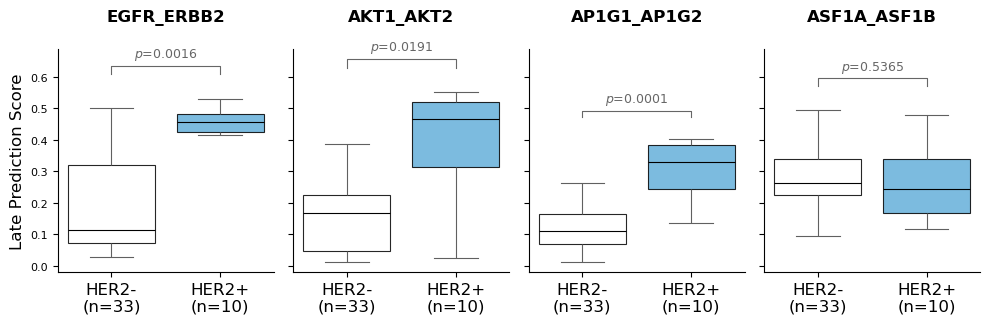

✓ Combined plot saved: /Users/narod/Library/CloudStorage/GoogleDrive-narod.kebabci@ucdconnect.ie/My Drive/GitRepos/context_specific_SL_prediction/figures/box_plots_her_combined_late_scores.png


In [142]:
selected_genepairs = ['EGFR_ERBB2', 'AKT1_AKT2', 'AP1G1_AP1G2', 'ASF1A_ASF1B']

fig, axes = plt.subplots(1, 4, figsize=(10, 3.85), sharey=True)

for i, gene_pair in enumerate(selected_genepairs):
    # Get the current axis
    ax = axes[i]
    
    # Filter data for this gene pair
    df = all_predictions_her_labeled[all_predictions_her_labeled['genepair'] == gene_pair].copy()
    df = df.dropna(axis=0, how='any', subset=['mut_binary']).reset_index(drop=True)
    df['mut_binary'] = df['mut_binary'].astype(int)
    
    if len(df) > 0:
        n_her_neg = (df['mut_binary'] == 0).sum()
        n_her_pos = (df['mut_binary'] == 1).sum()
        
        if n_her_neg > 0 and n_her_pos > 0:
            # Create box plot for this gene pair
            xticklabels = [f'HER2-\n(n={n_her_neg})', f'HER2+\n(n={n_her_pos})']
            draw_cont_graph(df, 'late_prediction_score', ax,
                           label='Late Prediction Score',
                           xticklabels=xticklabels,
                           draw_signif=True, hd=22)
            
            ax.set_title(gene_pair, fontsize=12, fontweight='bold', pad=20)
        else:
            ax.text(0.5, 0.5, f'{gene_pair}\nInsufficient data', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        ax.text(0.5, 0.5, f'{gene_pair}\nNo data', 
               ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

# Add overall title and layout
plt.tight_layout(rect=[0, 0.03, 1, 0.90])

# Save combined plot
combined_output_path = get_data_path(['figures'], 'box_plots_her_combined_late_scores.png')
plt.savefig(combined_output_path, dpi=500, bbox_inches='tight')
plt.show()

print(f"✓ Combined plot saved: {combined_output_path}")